In [5]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp
import matplotlib.animation as animation

In [6]:
def random_flower_attraction(features=2, num_flowers = 10, max_attraction = 10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_flowers) * max_attraction
def random_flower_position(num_flowers = 10, max_position = 10):
    # Random initial condition, only positive, numbers between 0 and max_position
    return np.random.rand(2, num_flowers) * max_position
def random_bee_position(num_bees = 10, max_position = 10):
    # Random initial condition x and y, only positive coordinates
    return np.random.rand(2, num_bees) * max_position
def random_bee_attraction(features=2, num_bees = 10, max_attraction=10):
    # Random initial condition, only positive, numbers between 0 and max_attraction
    return np.random.rand(features, num_bees) * max_attraction
def gauss_dist(norms, alpha):
    # Gaussian distance function
    return np.exp(-alpha*(norms**2))

In [19]:
def beehive_attraction(t):
    t_final = 2000
    # Behive attraction function
    return 100 / (1 + np.exp(-4*(t-t_final/2)))


def attraction_to_flower(attraction_differences, distance, distance_norms, t, final_pos, x_flat, alpha=1):
    """
    Include gamma array to modulate the attraction based on visited flowers.
    Params:
        mutual_attraction: features x num_flowers 
        mutual_distances: 2 x num_flowers
        gamma: array representing the attraction modulation
        max_velocity: float
    """
    # find the norm of the distance and the attraction
    attraction_norm = np.linalg.norm(attraction_differences, axis=0)
    velocity_unit_vector = distance / (distance_norms + 1e-8)
    print((velocity_unit_vector * gauss_dist(distance_norms, alpha)).shape)
    print(x_flat.shape)
    net_attraction = (velocity_unit_vector * gauss_dist(distance_norms, alpha) + beehive_attraction(t)*(final_pos - x_flat)) / (1 + attraction_norm)

    return net_attraction


In [20]:
flower_qnty = 10
bee_qnty = 1
max_attraction = 4
max_position = 100
features = 5
flower_positions = random_flower_position(num_flowers=flower_qnty, max_position=max_position)
bee_positions = random_bee_position(num_bees=bee_qnty, max_position=max_position)
bee_preferences = random_bee_attraction(features=features, num_bees=bee_qnty, max_attraction=max_attraction)
flower_attraction = random_flower_attraction(num_flowers=flower_qnty, features=features, max_attraction=max_attraction)

# Define parameters and initial conditions
t_steps = 5000
t_final = 2000
t_vals = np.linspace(0,t_final,t_steps)
nu = 3  # Parameter for the ODE
xsi = 0.2  # Parameter for the ODE
alpha = 0.2 / max_position  # Parameter for the ODE
eps = 5  # Proximity threshold for flower visitation

seconds_at_flower =  2
attraction_differences = bee_preferences[:, :, np.newaxis] - flower_attraction[:, np.newaxis, :]  # Shape -> (num_features, num_bees, num_flowers)
T_i = np.ones((bee_qnty, flower_qnty))
final_pos = random_bee_position(num_bees=1, max_position=max_position)
def ode(t, x_flat, T_i, final_pos):

    # Reshape x back to its original 2D shape
    x = x_flat.reshape((2, -1))
    distance = flower_positions[:, np.newaxis, :] - x[:, :, np.newaxis]
    distance_norms = np.linalg.norm(distance, axis=0)
    T_i -= (distance_norms < eps) * ((t_final / t_steps) * (1 / seconds_at_flower))
    gamma = T_i > 0

    attractors = attraction_to_flower(attraction_differences, distance, distance_norms, t, final_pos, x_flat, alpha)

    attractors = attractors*gamma

    combined_vector = attractors.sum(axis=2)
    
    velocity = (nu * combined_vector) / (xsi + np.linalg.norm(combined_vector, axis=0))

    # return the velocity for each bee
    return velocity.flatten()

# ode(0, bee_positions, T_i)

solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i, final_pos), dense_output=True)

# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plt.figure(figsize=(10, 6))



for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories_reshaped[0, i, :]
    y = trajectories_reshaped[1, i, :]
    plt.plot(x, y, label=f'Bee {i+1}')

plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
# plot the flowers
plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.xlim(-5,max_position + 5)
plt.ylim(-5,max_position + 5)
plt.legend()

plt.show()


(2, 1, 10)
(2,)


/tmp/ipykernel_21347/2098771929.py:4: RuntimeWarning: overflow encountered in exp
  return 100 / (1 + np.exp(-4*(t-t_final/2)))


ValueError: operands could not be broadcast together with shapes (2,1,10) (2,2) 

1


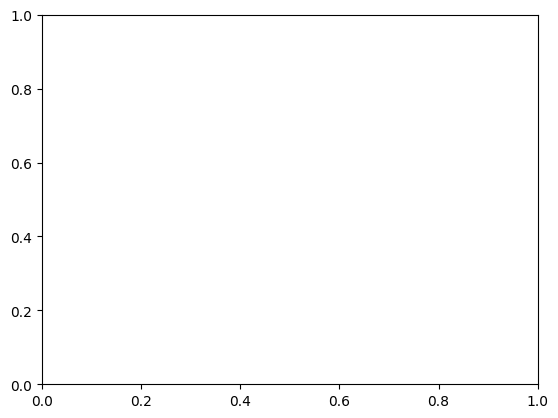

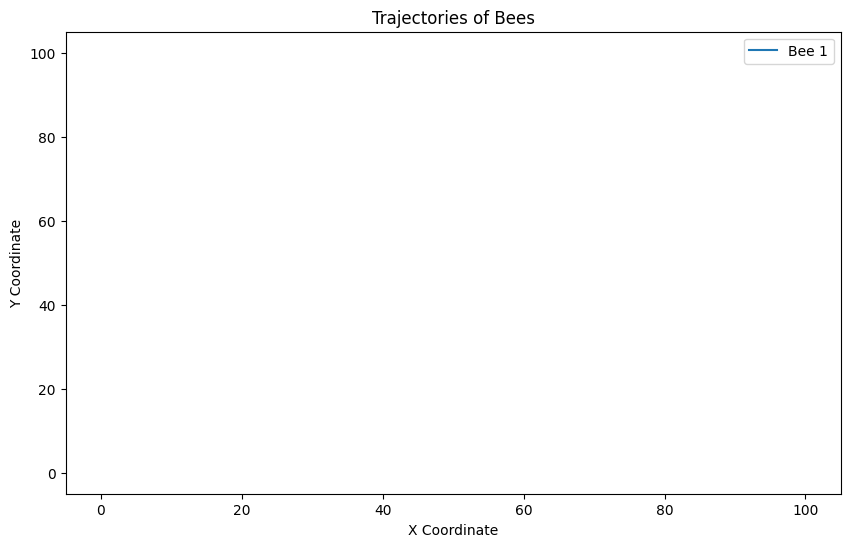

In [24]:
# Create the plot axes
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


solution = solve_ivp(ode, (0,t_final), bee_positions.flatten(), t_eval=t_vals, args=(T_i,), dense_output=True)

# Extract the solution
trajectories = solution.y

# Reshape the trajectories to (2, num_bees, num_time_points)
num_bees = bee_qnty
num_time_points = trajectories.shape[1]
trajectories_reshaped = trajectories.reshape((2, num_bees, num_time_points))

plt.figure(figsize=(10, 6))

for i in range(num_bees):
    # Extracting the x and y coordinates of the i-th bee
    x = trajectories_reshaped[0, i, :]
    y = trajectories_reshaped[1, i, :]
    plt.plot(x, y, label=f'Bee {i+1}')

# plt.scatter(bee_positions[0, :], bee_positions[1, :], label='Starting Positions')
# # plot the flowers
# plt.scatter(flower_positions[0, :], flower_positions[1, :], marker='x', color='r', label='Flower Positions')

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Trajectories of Bees')
plt.xlim(-5,max_position + 5)
plt.ylim(-5,max_position + 5)
plt.legend()
plt.show()

# set limits
ax.set_xlim(-5,max_position + 5)
ax.set_ylim(-5,max_position + 5)

# create the line object
line, = ax.plot([], [], 'r-')

# Define the update function
def update(t):
    line.set_data(solution.y[0][:t], solution.y[1][:t])

# run the animation
# ani = animation.FuncAnimation(fig, update, frames=solution.y.shape[1] - 4000, interval=5)
# 
# ani.save("bee_animation.mp4")




In [33]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import convolve
# 
# def h(x):
#     return np.piecewise(x, [x <= -1/3, x >= 1/3], [-1, 1, lambda x: 3 * x])
# 
# A = 1/4
# def G(x):
#     return np.exp(-(x/A)**2/2)/(A * np.sqrt(2 * np.pi))
# 
# def H(y):
#     return convolve(h(x), G(x), mode='same')
# 
# def L(x):
#     return H(np.sin(x))
# 
# x = np.linspace(-2, 2, 1000)
# plt.figure(figsize=(10, 6))
# 
# # plt.subplot(3, 1, 1)
# # plt.plot(x, h(x))
# # plt.title('h(x)')
# # plt.xlabel('x')
# # plt.grid(True)
# # 
# # plt.subplot(3, 1, 2)
# # plt.plot(x, H(x))
# # plt.title('H(x)')
# # plt.xlabel('x')
# # plt.grid(True)
# 
# x = np.linspace(-5, 5, 1000)
# # plt.subplot(3, 1, 3)
# plt.plot(x, L(x))
# plt.title('L(x)')
# plt.xlabel('x')
# plt.grid(True)
# 
# plt.tight_layout()
# plt.show()
